In [2]:
import pandas as pd
import numpy as np

In [215]:
import re

1.模拟markowitz策略，能否跑赢hs300
用前五年的数据，来估计expected return 和variance等超参数
每半年时间调整一下portfolio
假设无交易成本
需要生成每日的porfolio数据
perfomance，假设15年净值为1
画图：自己的portfolio，HS300，都从1开始
也可以尝试一下另一种策略，每一个股票2%，当然也需要rebalance
假设可以做空，为了求解（也可以不做空，尝试优化）

2.线性回归

3.option pricing

In [15]:
from scipy.optimize import minimize

In [ ]:
def cal_real_return(data,port,start,end):
    

In [375]:
class Marko():
    
    def __init__(self,raw_data_path):
        self.raw_data = pd.read_excel(raw_data_path)
        self.timecolumns = self.raw_data.columns[2:]#抽取时间轴
        self.clean()#清洗
        self.get_startend_dates()
        self.get_startend_tradeday()
        self.get_returns_data()
        self.performance_withrf_allowshort = pd.DataFrame()
        self.marketreturns = self.marketreturns["20150105":"20191231"].cumsum()#只需要后半数据的累加
        self.marketreturns = pd.DataFrame(self.marketreturns.values.reshape(1,len(self.marketreturns.index)),columns=self.marketreturns.index)
        self.get_portfolio_strategy()
        self.cal_real_return()
    
    def clean(self):#dataframe作为参数会更改原变量
        '''
        清洗数据,以上一期数据代替这一期空值
        input:raw data , type:dataframe
        output:tidy data, type:dataframe
        '''
        self.data = self.raw_data #清洗后的数据,用于之后每次计算return和sigma
        data_isnull = self.raw_data.isnull() 
        for i in range(self.data.shape[0]):
            for j in range(self.data.shape[1]):
                if data_isnull.iloc[i,j]:
                    if j == 2:#有一行数据第一个交易日没有数据，用下一期数据代替（下一期数据存在）
                        self.data.iloc[i,j] = self.data.iloc[i,j+1]
                    else:
                        self.data.iloc[i,j] = self.data.iloc[i,j-1]
    
    def get_startend_dates(self):
        '''
        生成各stage的配置portfolio timerange的起始点和终止点
        '''
        self.starts = []
        self.ends = []
        
        for i in range(10):
            if i%2 == 0:
                starthead = "201%s01"%(i//2) #一月第一个
                endhead = "201%s12"%(i//2+4) #十二月最后一个
            else:
                starthead = "201%s07"%(i//2) #七月第一个
                endhead = "201%s06"%(i//2+5)#六月最后一个
            targetcols_start = [] #存放所有匹配的一个月的时间
            targetcols_end = []
            for col in self.timecolumns:
                if re.match(starthead,col):
                    targetcols_start.append(col)
                if re.match(endhead,col):
                    targetcols_end.append(col)
            start = targetcols_start[0]
            end = targetcols_end[-1]
            self.starts.append(start)
            self.ends.append(end)
            
    def get_startend_tradeday(self):
        '''
        生成各stage的根据port进行trade的起始点和终止点
        '''
        self.starts_trade = []
        self.ends_trade = []
        
        for i in range(10):
            if i%2 == 0:#上半年
                starthead = "201%s01"%(i//2+5) 
                endhead = "201%s06"%(i//2+5)
            else:#下半年
                starthead = "201%s07"%(i//2+5)
                endhead = "201%s12"%(i//2+5)
            targetcols_start = []
            targetcols_end = []
            for col in self.timecolumns:
                if re.match(starthead,col):
                    targetcols_start.append(col)
                if re.match(endhead,col):
                    targetcols_end.append(col)
            start = targetcols_start[0]
            end = targetcols_end[-1]
            self.starts_trade.append(start)
            self.ends_trade.append(end)
    
    def obj_func(self,sigma):
        '''
        目标函数
        '''
        fun = lambda x:x.T@sigma@x
        return fun
    
    def cons(self,exp_return):
        '''
        约束函数
        '''
        con = ({"type":"eq","fun":lambda x :np.dot(x,exp_return)-0.1},
              {"type":"eq","fun":lambda x:np.sum(x)-1})
        return con
    
    def get_returns_data(self):
        '''
        得到全局每日50只股票日收益率与市场收益率
        '''
        trade_data = self.data.iloc[:,2:]
        globalreturns = np.log(trade_data/trade_data.shift(axis = 1))
        self.stockreturns,self.marketreturns = globalreturns.iloc[1:,:],globalreturns.iloc[0,:] #将market portofolio数据分离
        self.stockreturns.loc[51,:] = [0.03/252]*globalreturns.shape[1] #将risk-free asset加入
        
    
    def get_portfolio_onestage(self,start,end):
        '''
        通过前五年数据获取各股票参数
        start，起始时间
        end,截止时间
        output:portfolio,资产配置组合
        type:array
        '''
        returns_onestage = self.stockreturns.loc[:,start:end]#日收益率
    
        exp_return = returns_onestage.transpose().mean()*252 #年化收益率
    
        sigma = returns_onestage.transpose().cov()*252 #年化协方差矩阵
        w_ini = [0.02]*51
        portfolio_onestage = minimize(fun=obj_func(sigma),x0=w_ini,constraints=cons(exp_return)).x
        
        return portfolio_onestage
    
    def get_portfolio_strategy(self):
        '''
        输出整个timeline各个stage的portfolio
        '''
        self.ports = {}
        for i in range(len(starts)):
            port =  self.get_portfolio_onestage(start=self.starts[i],end=self.ends[i])
            col = "stage%s"%(i+1)
            self.ports[col] = port
            self.ports = pd.DataFrame(self.ports)
            
    def cal_real_return_onestage(self,start,end,port):
        '''
        根据port计算单阶段内每日实际收益情况，可适应多种假设
        '''
        returns_onestage = self.stockreturns.loc[:,start:end]
        perf = []
        for col in returns_onestage.columns:
            perf.append(np.dot(port,returns_onestage[col]))
        performance_df = pd.DataFrame(np.array(perf).reshape(1,len(returns_onestage.columns)),columns = returns_onestage.columns)
        self.performance_withrf_allowshort = pd.concat([self.performance_withrf_allowshort,performance_df],axis=1)
    
    def cal_real_return(self):
        '''
        计算整个timerange每日实际收益情况,可适应多种假设
        '''
        for i in range(len(self.ports.columns)):
            port = self.ports.iloc[:,i]
            start = self.starts_trade[i]
            end = self.ends_trade[i]
            self.cal_real_return_onestage(start,end,port)
        self.performance_withrf_allowshort.cumsum()
            
    def perf_plot(self):
        '''
        绘图
        '''
        plt.figure(figsize=(30,10))
        plt.xticks(rotation = 360)
        plt.plot(self.marketreturns.columns,self.marketreturns.values.flatten(),label="HS300",linestyle=":")
        plt.plot(self.performance_withrf_allowshort.columns,self.performance_withrf_allowshort.values.flatten(),label="Marko portfolio(short-allowed)")
        plt.legend()
        plt.xticks([])
        plt.show()
        

In [328]:
from matplotlib import pyplot as plt

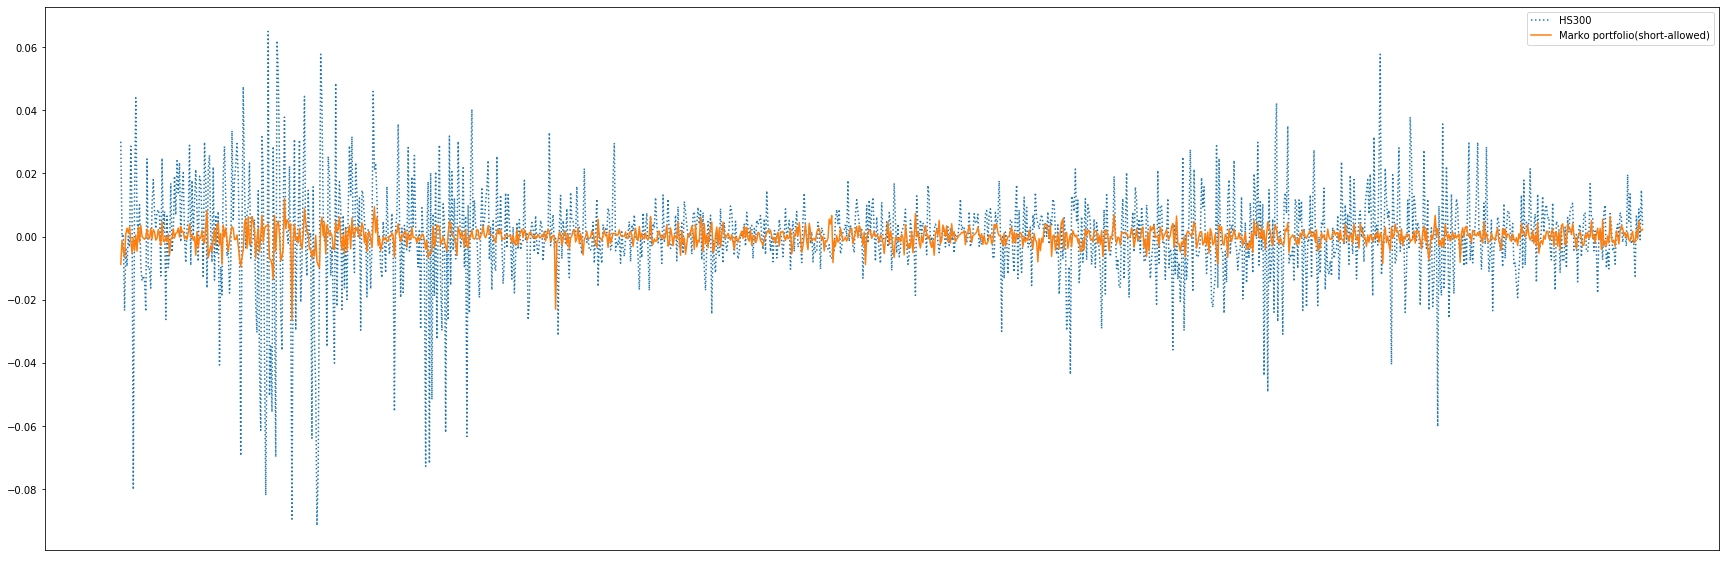

In [352]:
plt.figure(figsize=(30,10))
plt.xticks(rotation = 360)
plt.plot(market.index,market.values.flatten(),label="HS300",linestyle=":")
plt.plot(m.performance_withrf_allowshort.columns,m.performance_withrf_allowshort.values.flatten(),label="Marko portfolio(short-allowed)")
plt.xticks([])
plt.legend()
plt.show()

In [376]:
m = Marko("HW1.xlsx")

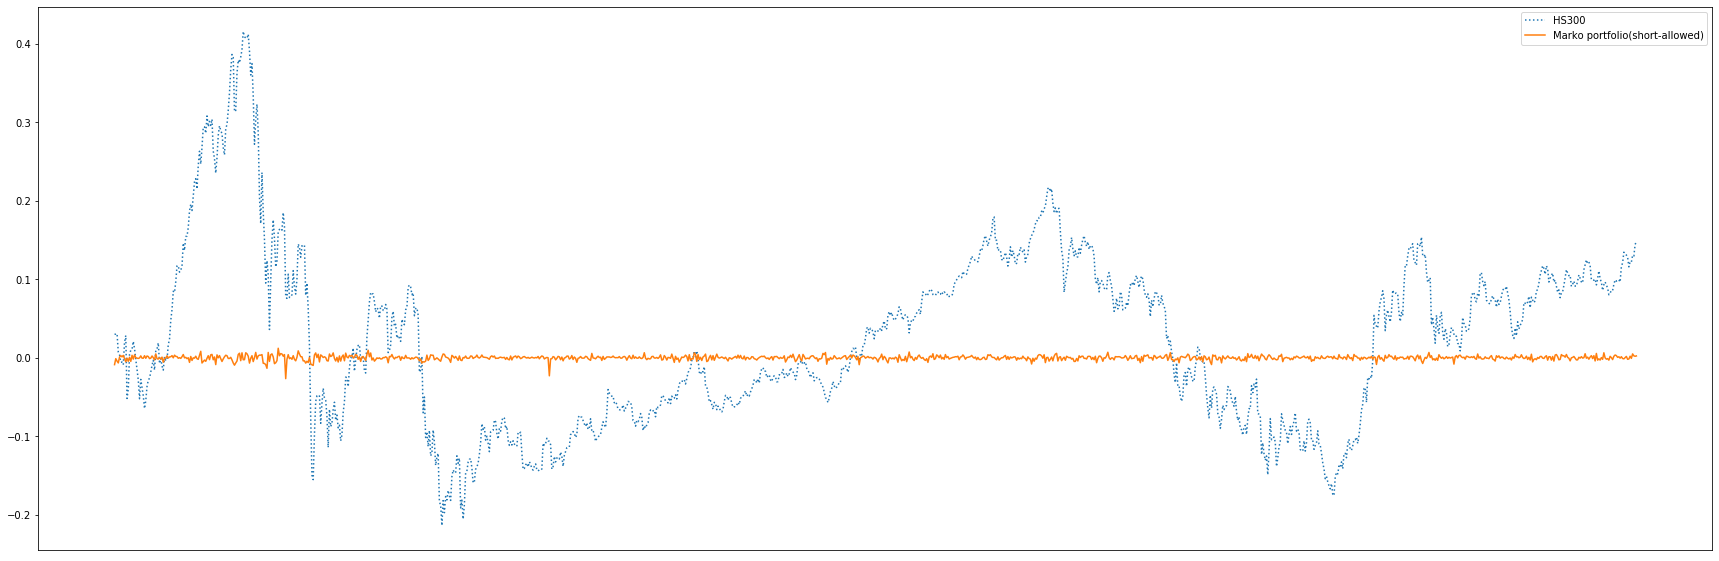

In [377]:
m.perf_plot()

In [364]:
test = m.marketreturns[0]

In [366]:
np.array(test)

array([0.03006119, 0.02992937, 0.03067887, ..., 0.12944127, 0.14415094,
       0.147807  ])

In [371]:
pd.DataFrame(test.values.reshape(1,len(test.index)),columns=test.index)

,20150105,20150106,20150107,20150108,20150109,20150112,20150113,20150114,20150115,20150116,...,20191218,20191219,20191220,20191223,20191224,20191225,20191226,20191227,20191230,20191231
0,0.030061,0.029929,0.030679,0.007207,0.003678,-0.00571,-0.005579,-0.008891,0.019732,0.028305,...,0.13211,0.130713,0.128252,0.11569,0.122187,0.121664,0.130425,0.129441,0.144151,0.147807


# Q2

In [472]:
class CAPM():
    
    def __init__(self,path):
        self.raw_data = pd.read_excel(path)
        self.clean()
        self.random_state = 1234
        self.get_returns_data()
        self.marketreturns = pd.DataFrame(self.marketreturns.values.reshape(1,len(self.marketreturns.index)),columns=self.marketreturns.index)
        self.sample()
        self.cal_beta()
        self.regression()
    
    def clean(self):#dataframe作为参数会更改原变量
        '''
        清洗数据,以上一期数据代替这一期空值
        input:raw data , type:dataframe
        output:tidy data, type:dataframe
        '''
        self.data = self.raw_data #清洗后的数据,用于之后每次计算return和sigma
        data_isnull = self.raw_data.isnull() 
        for i in range(self.data.shape[0]):
            for j in range(self.data.shape[1]):
                if data_isnull.iloc[i,j]:
                    if j == 2:#有一行数据第一个交易日没有数据，用下一期数据代替（下一期数据存在）
                        self.data.iloc[i,j] = self.data.iloc[i,j+1]
                    else:
                        self.data.iloc[i,j] = self.data.iloc[i,j-1]
    
    def get_returns_data(self):
        '''
        得到全局每日50只股票日收益率与市场收益率
        '''
        trade_data = self.data.iloc[:,2:]
        globalreturns = np.log(trade_data/trade_data.shift(axis = 1))
        self.stockreturns,self.marketreturns = globalreturns.iloc[1:,:],globalreturns.iloc[0,:] #将market portofolio数据去掉
        #self.stockreturns.loc[51,:] = [0.03/252]*globalreturns.shape[1] #将risk-free asset加入
    
    def sample(self):
        '''
        抽样与融合
        '''
        self.fiv_stock_data = self.stockreturns.sample(5,random_state=self.random_state)
        self.fiv_stock_data = self.fiv_stock_data.append(self.marketreturns)
    
    def cal_beta(self):
        '''
        直接计算beta
        '''
        self.sigma = self.fiv_stock_data.transpose().cov() #协方差矩阵,不用年化
        beta = []
        for i in range(self.sigma.shape[1]-1):
            beta.append(self.sigma.iloc[i,5]/self.sigma.iloc[5,5])
        beta.append(1)
        self.sigma["beta"] = beta
        self.beta_alpha = pd.DataFrame(self.sigma["beta"]).iloc[:5]
    
    def regression(self):
        '''
        回归计算beta和alpha,以及alpha的p值
        '''
        self.x_y = self.fiv_stock_data - 0.03/252
        self.y,self.x = self.x_y.iloc[:5,1:],self.x_y.iloc[5,1:]
        x_withcon = sm.add_constant(self.x)
        beta_reg = []
        alpha = []
        alpha_pval = []
        for i in range(self.y.shape[0]):
            exec("self.y{} = {}".format(i,list(np.array(self.y.iloc[i,:]))))
            self.x_withcon = sm.add_constant(self.x)
            exec("self.mod{} = sm.OLS(self.y{},x_withcon)".format(i,i))
            exec("self.regresult{} = self.mod{}.fit()".format(i,i))
            exec("beta_reg.append(self.regresult{}.params[0])".format(i))
            exec("alpha.append(self.regresult{}.params['const'])".format(i))
            exec("alpha_pval.append(self.regresult{}.pvalues['const'])".format(i))
        self.beta_alpha["beta_reg"] = beta_reg
        self.beta_alpha["alpha"] = alpha
        self.beta_alpha["alpha_pval"] = alpha_pval
            

In [419]:
import statsmodels.api as sm

In [473]:
capm = CAPM("HW1.xlsx")

# Q3

In [496]:
class BinaryTree():#只适用看跌期权
    
    def __init__(self,K,S0,expire_t,vol,rf,m,American=False):
        '''
        看跌期权
        K:行权价
        S0:股票期初价
        expire_t:行权期限,以年计
        vol:波动率,年化
        rf:risk-free rate,年化
        m:step
        American:是否美式期权
        '''
        self.K = K
        self.S0 = S0
        self.expire_t = expire_t
        self.vol = vol
        self.rf = rf
        self.m = m
        self.American = American
        
        self.u = np.exp(self.vol*np.sqrt(self.expire_t/self.m))#upper
        self.d = 1/self.u
        self.q = (np.exp(self.rf*(self.expire_t/self.m)) - self.d) / (self.u - self.d)#upper prob
        
        self.disc = np.exp(-rf*self.expire_t/self.m)
        
        self.cal()
        
    def cal_eur(self):
        '''
        '''
        mu = np.arange(self.m+1)
        mu = np.resize(mu,(self.m+1,self.m+1))
        md = np.transpose(mu)
        
        mu = self.u ** (mu-md)
        md = self.d ** md
        
        self.S = self.S0 * mu * md
        
        self.V = np.maximum(self.K - self.S, 0)
        
        for i in range(self.m):
            self.V[0:self.m - i, self.m - i - 1] = (self.q * self.V[0:self.m - i, self.m - i] +
                         (1 - self.q) * self.V[1:self.m - i + 1, self.m - i]) * self.disc
        return self.V[0,0]
        
    def cal_ame(self):
        '''
        
        '''
        mu = np.arange(self.m+1)
        mu = np.resize(mu,(self.m+1,self.m+1))
        md = np.transpose(mu)
        
        mus = self.u ** (mu-md)
        mds = self.d ** md
        
        self.S = self.S0 * mus * mds
        
        self.S_E = self.S0 * 1/disc **mu
        
        self.V = np.maximum(self.K-self.S,0)
        ame_return = self.K - self.S_E
        
        for i in range(self.m):
            ame_value = (self.q * self.V[0:self.m-i,self.m-i]+
                        (1-self.q)*self.V[1:self.m-i+1,self.m-i])*disc
            self.V[0:self.m-i,self.m-i-1] = np.maximum(ame_value,ame_return[0:self.m-i,self.m-i-1])
        
        return self.V[0,0]
    
    def cal(self):
        if self.American:
            self.cal_ame()
        else:
            self.cal_eur()
    

In [497]:
bi = BinaryTree(30,30,1,0.35,0.03,10)

In [498]:
bi

In [490]:
30*np.exp(0.35*np.sqrt(1/10))

33.51111248407701

In [491]:
bi.root.u_child.s

33.51111248407701

In [485]:
class Node():
    
    def __init__(self,s,f=None,father = None,u_child = None,d_child=None):
        '''
        s:此节点股价
        f:此节点期权价
        '''
        self.s = s
        self.father = father
        self.u_child = u_child
        self.d_child = d_child

In [481]:
class BinaryTree():#只适用看跌期权
    
    def __init__(self,K,S0,expire_t,vol,rf,m,American=False):
        '''
        看跌期权
        K:行权价
        S0:股票期初价
        expire_t:行权期限,以年计
        vol:波动率,年化
        rf:risk-free rate,年化
        m:step
        American:是否美式期权
        '''
        self.K = K
        self.S0 = S0
        self.expire_t = expire_t
        self.vol = vol
        self.rf = rf
        self.m = m
        self.American = American
        
        self.u = np.exp(self.vol*np.sqrt(self.expire_t/self.m))#upper
        self.d = 1/self.u
        self.p = (np.exp(self.rf*(self.expire_t/self.m)) - self.d) / (self.u - self.d)#upper prob
        
        self.root = Node(s=self.S0)#根节点
        self.leaflist = []#叶节点列表
        
        self.layers = 0#计算当前树的层数
        
        self.forward(self.root)
        
        
        
    def forward(self,node):
        '''
        前向创建节点并赋值
        '''
        node.u_child = Node(s=node.s*self.u,father=node)
        node.d_child = Node(s=node.s*self.d,father=node)
        
        self.layers += 1
        
        if self.layers < self.m :
            self.forward(node.u_child)
            self.forward(node.d_child)
    
    def backword(self):
        '''
        
        '''
        
        pass